In [5]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd

class TableGAN:
    def __init__(self, input_dim, output_dim, z_dim=100, y_dim=None):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.generator = None
        self.discriminator = None
        self.gan = None
        self._scaler = MinMaxScaler(feature_range=(-1, 1))
        self._label_encoder = LabelEncoder()

    def fit(self, x, y=None, batch_size=32, epochs=200, verbose=1):
        x, y = self.preprocess_data(x, y)
        x = self._scaler.fit_transform(x)
        if y is not None:
            y = self._label_encoder.fit_transform(y.astype(int)).reshape(-1, 1)
        
        self._build_generator()
        self._build_discriminator()
        self._build_gan()

        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            for _ in range(len(x) // batch_size):
                # Train discriminator
                idx = np.random.randint(0, x.shape[0], batch_size)
                real_data = x[idx]
                noise = self._generate_noise(batch_size)
                fake_data = self.generator(noise, training=False)
                
                with tf.GradientTape() as tape:
                    real_output = self.discriminator(real_data, training=True)
                    fake_output = self.discriminator(fake_data, training=True)
                    d_loss = self._discriminator_loss(real_output, fake_output)
                
                gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
                self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
                d_losses.append(d_loss)

                # Train generator
                noise = self._generate_noise(batch_size)
                with tf.GradientTape() as tape:
                    generated_data = self.generator(noise, training=True)
                    fake_output = self.discriminator(generated_data, training=False)
                    g_loss = self._generator_loss(fake_output)
                
                gradients = tape.gradient(g_loss, self.generator.trainable_variables)
                self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
                g_losses.append(g_loss)

            if verbose and epoch % 10 == 0:
                d_loss_mean = np.mean(d_losses)
                g_loss_mean = np.mean(g_losses)
                print(f"Epoch {epoch}/{epochs}: [D loss: {d_loss_mean:.4f}] [G loss: {g_loss_mean:.4f}]")

        return self

    def _discriminator_loss(self, real_output, fake_output):
        real_loss = tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)
        return fake_loss - real_loss

    def _generator_loss(self, fake_output):
        return -tf.reduce_mean(fake_output)

    def _build_generator(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, input_dim=self.z_dim),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(self.output_dim, activation='tanh')
        ])
        self.generator = model
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    def _build_discriminator(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, input_shape=(self.output_dim,)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(256),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(1)
        ])
        self.discriminator = model
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    def _build_gan(self):
        self.gan = tf.keras.Sequential([self.generator, self.discriminator])

    def _generate_noise(self, batch_size):
        return tf.random.normal([batch_size, self.z_dim])

    def sample(self, n_samples):
        noise = self._generate_noise(n_samples)
        synthetic_data = self.generator(noise, training=False)
        return self._inverse_transform(synthetic_data.numpy())

    def _inverse_transform(self, data):
        return self._scaler.inverse_transform(data)

    def load_dataset(self, dataset_name):
        data_path = f'data/{dataset_name}/train_{dataset_name}_cleaned.csv'
        label_path = f'data/{dataset_name}/train_{dataset_name}_labels.csv'

        X = pd.read_csv(data_path)  # Remove sep=';' as it's comma-separated
        if self.y_dim:
            y = np.loadtxt(label_path)  # Use np.loadtxt for the labels
            return X, y
        return X, None
    
    def preprocess_data(self, X, y=None):
        # Convert all columns to numeric
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # Drop rows with NaN values
        X = X.dropna()

        # Reset index after dropping rows
        X = X.reset_index(drop=True)

        if y is not None:
            # Ensure y has the same number of rows as X
            y = y[:len(X)]

        return X, y

In [6]:
# Load and preprocess the data
temp_gan = TableGAN(input_dim=1, output_dim=1, y_dim=1)
X, y = temp_gan.load_dataset('Adult')
X, y = temp_gan.preprocess_data(X, y)

# Create and train the TableGAN model
gan = TableGAN(input_dim=X.shape[1], output_dim=X.shape[1], z_dim=100, y_dim=1)
gan.fit(X, y, epochs=200, batch_size=32)

# Generate synthetic samples
synthetic_data = gan.sample(1000)

c:\Users\tahat\anaconda3\envs\chatbot\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\tahat\anaconda3\envs\chatbot\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 0/200: [D loss: -2.8828] [G loss: -0.3183]
Epoch 10/200: [D loss: -0.4432] [G loss: -6.2186]
Epoch 20/200: [D loss: -0.2276] [G loss: -3.0034]
Epoch 30/200: [D loss: -0.8492] [G loss: 1.7114]
Epoch 40/200: [D loss: 0.1681] [G loss: -3.5200]
Epoch 50/200: [D loss: 0.9072] [G loss: -12.4732]
Epoch 60/200: [D loss: 1.0451] [G loss: -16.1106]
Epoch 70/200: [D loss: 0.3266] [G loss: -27.0950]
Epoch 80/200: [D loss: -1.3293] [G loss: -25.7906]
Epoch 90/200: [D loss: -4.4237] [G loss: -12.0955]
Epoch 100/200: [D loss: -1.4776] [G loss: -40.1890]
Epoch 110/200: [D loss: -2.3438] [G loss: -27.4103]
Epoch 120/200: [D loss: -0.5720] [G loss: -25.7738]
Epoch 130/200: [D loss: -2.6694] [G loss: -58.1062]
Epoch 140/200: [D loss: -4.4847] [G loss: -52.6996]
Epoch 150/200: [D loss: -4.0953] [G loss: -72.5806]
Epoch 160/200: [D loss: -6.2842] [G loss: -14.6983]
Epoch 170/200: [D loss: -3.6574] [G loss: -88.9028]
Epoch 180/200: [D loss: -4.6061] [G loss: -89.1195]
Epoch 190/200: [D loss: -8.4290] 

In [7]:
def post_process_synthetic_data(synthetic_data, original_data):
    # Create a DataFrame with the same column names as the original data
    df_synthetic = pd.DataFrame(synthetic_data, columns=original_data.columns)
    
    for column in df_synthetic.columns:
        # Check if the original column contains only integers
        if original_data[column].dtype in ['int64', 'int32']:
            df_synthetic[column] = df_synthetic[column].round().astype(int)
        else:
            # For float columns, round to the same number of decimal places as in the original data
            decimals = original_data[column].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0).max()
            df_synthetic[column] = df_synthetic[column].round(decimals)
    
    return df_synthetic

In [8]:
# Post-process the synthetic data
processed_synthetic_data = post_process_synthetic_data(synthetic_data, X)

print(processed_synthetic_data.head())

   age  workclass  fnlwgt  education  education-num  marital-status  \
0   41          2  181793          3             11               1   
1   27          3  151311          2             11               2   
2   64          6  163107          1             12               1   
3   31          0  201072          4              9               3   
4   69          4  216462          2             11               1   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           6             3     1    2          1081             0   
1           7             3     1    2             5             0   
2           1             3     1    2             3             0   
3           7             3     5    1            97             0   
4           2             3     1    2            72             0   

   hours-per-week  native-country  
0              43               2  
1              30               0  
2              34               1  
3       

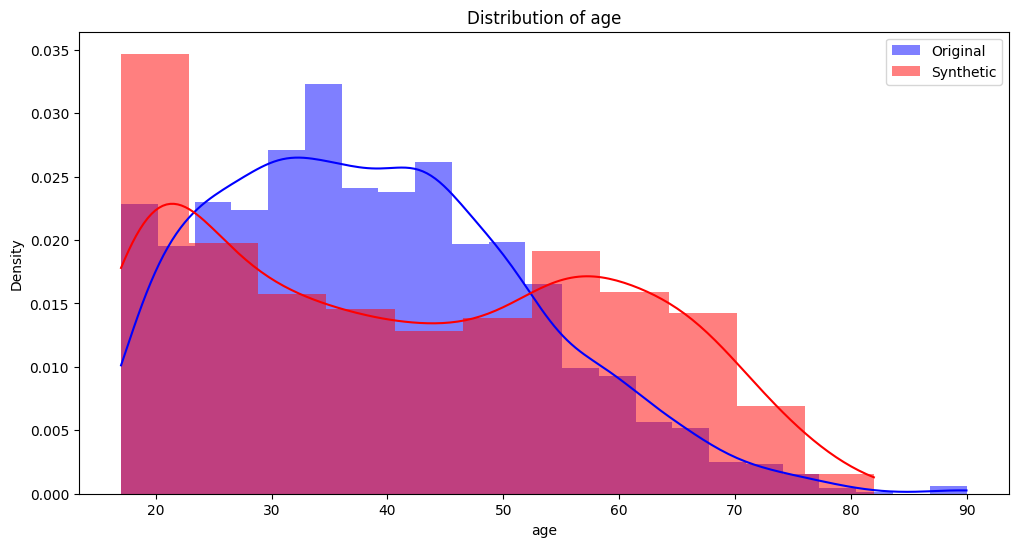

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_distributions(original, synthetic, feature_name):
    plt.figure(figsize=(12, 6))
    sns.histplot(original[feature_name], color="blue", kde=True, stat="density", linewidth=0, label="Original")
    sns.histplot(synthetic[feature_name], color="red", kde=True, stat="density", linewidth=0, label="Synthetic")
    plt.title(f'Distribution of {feature_name}')
    plt.legend()
    plt.show()

# Example usage for a feature
compare_distributions(X, processed_synthetic_data, 'age')

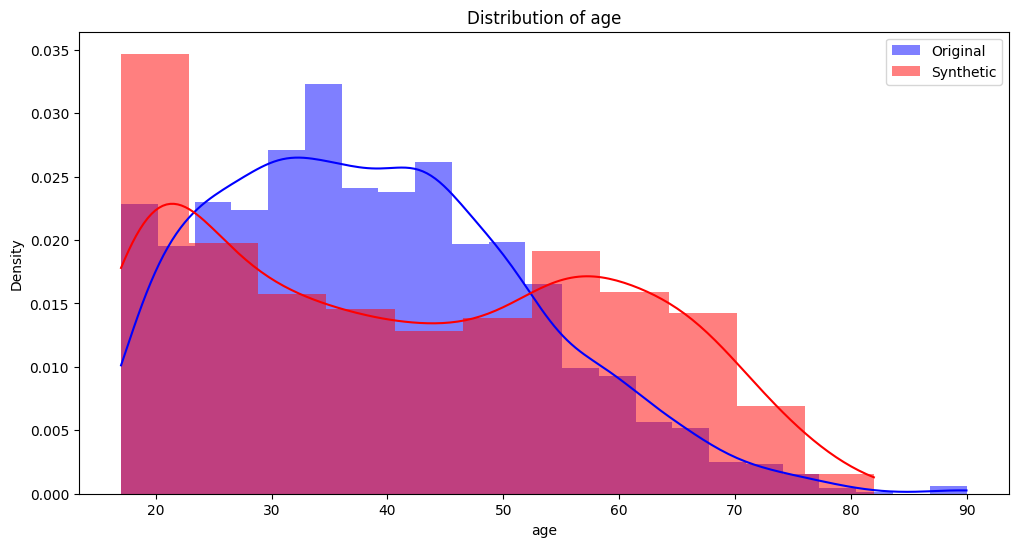

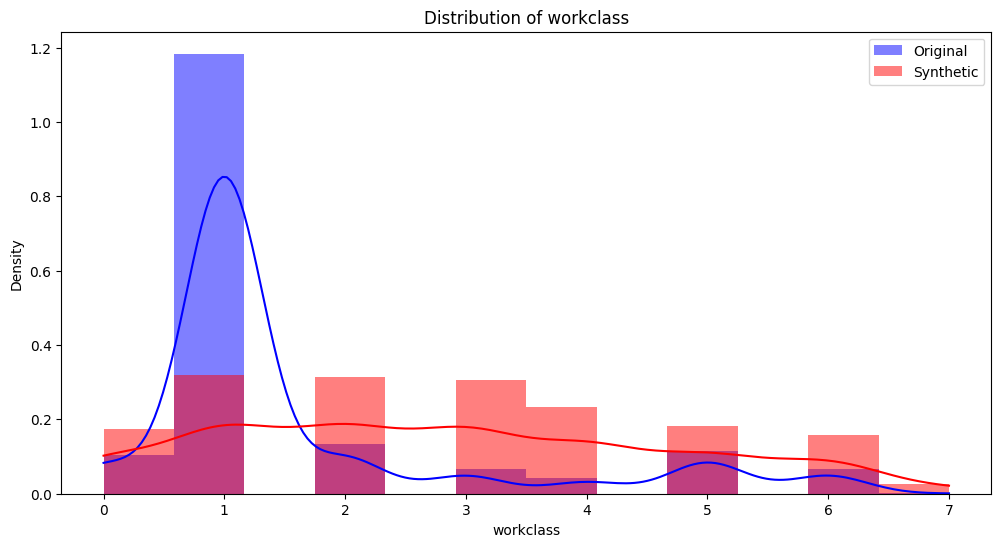

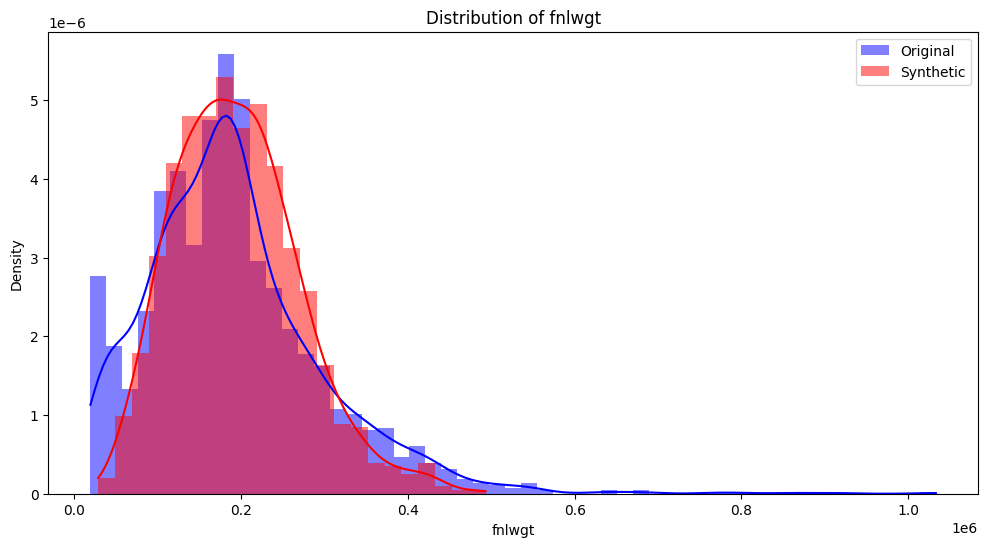

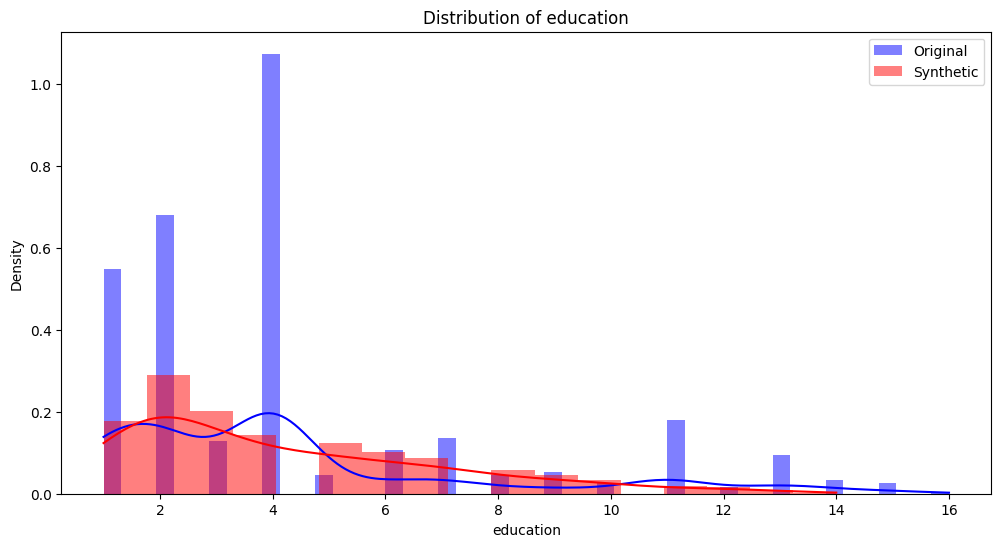

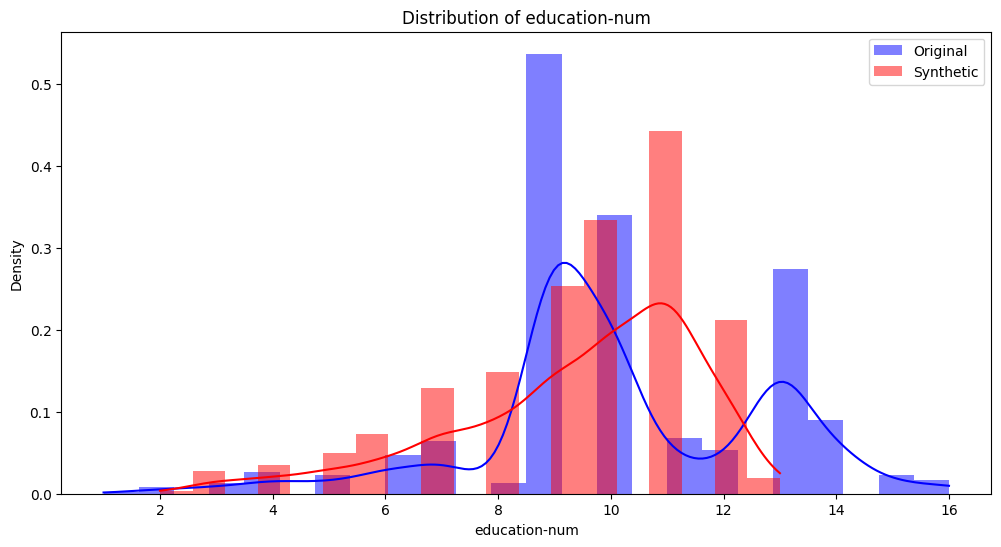

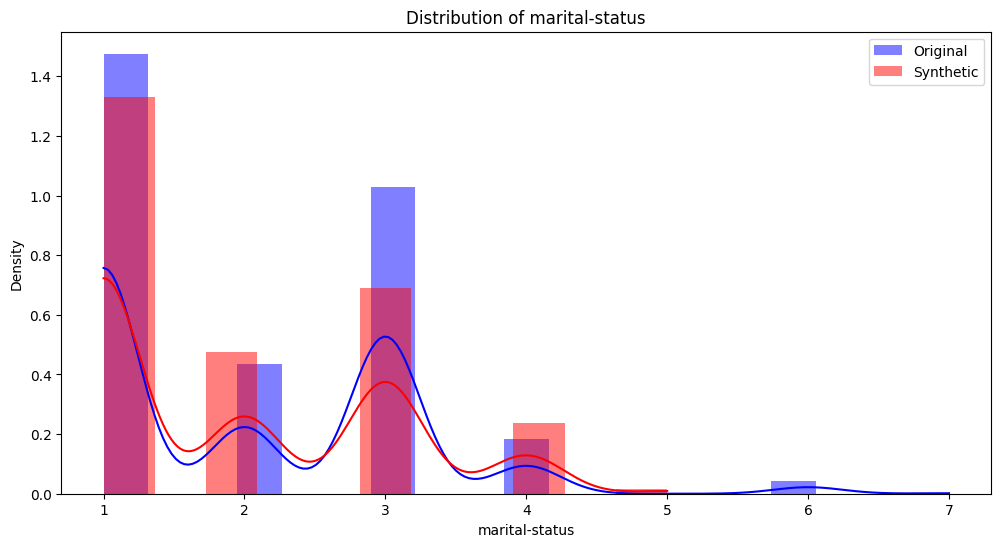

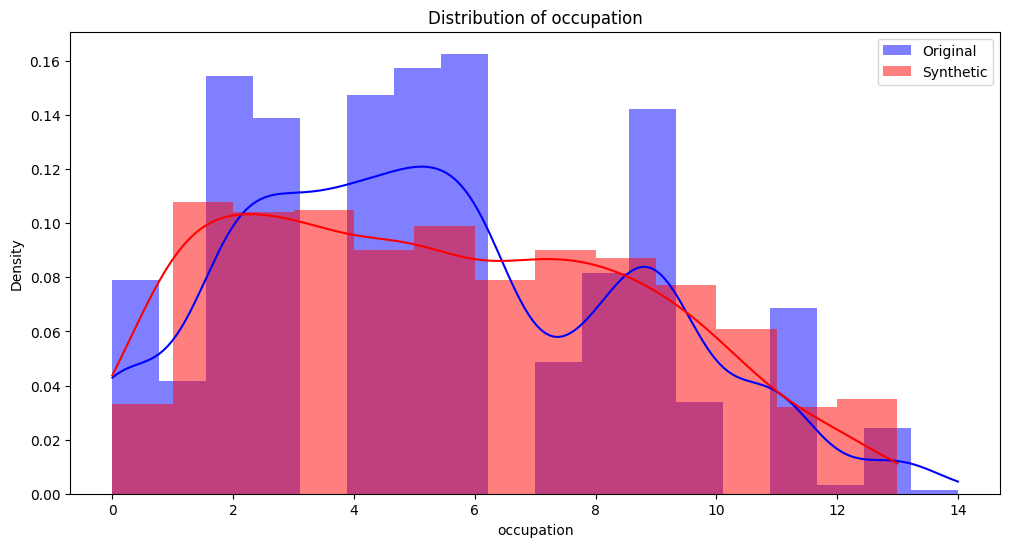

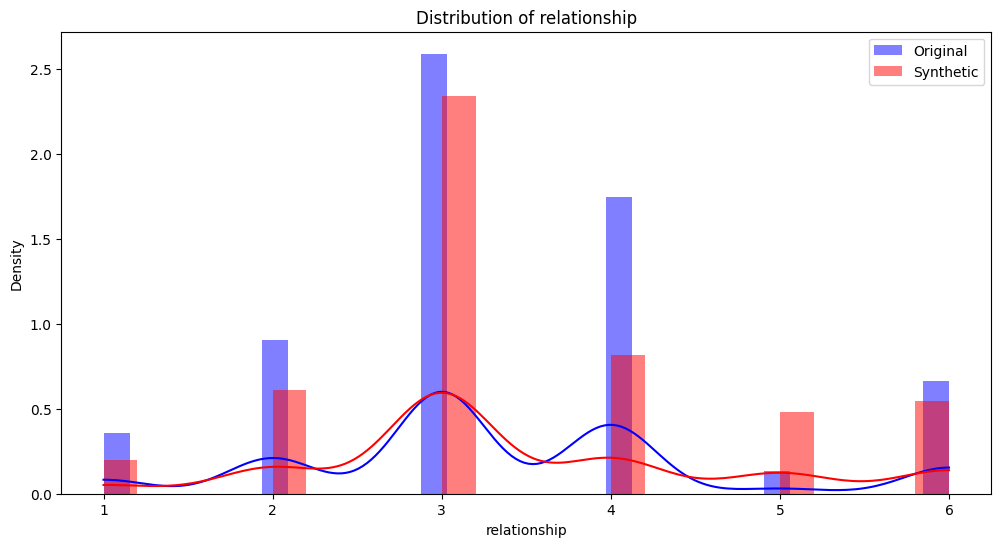

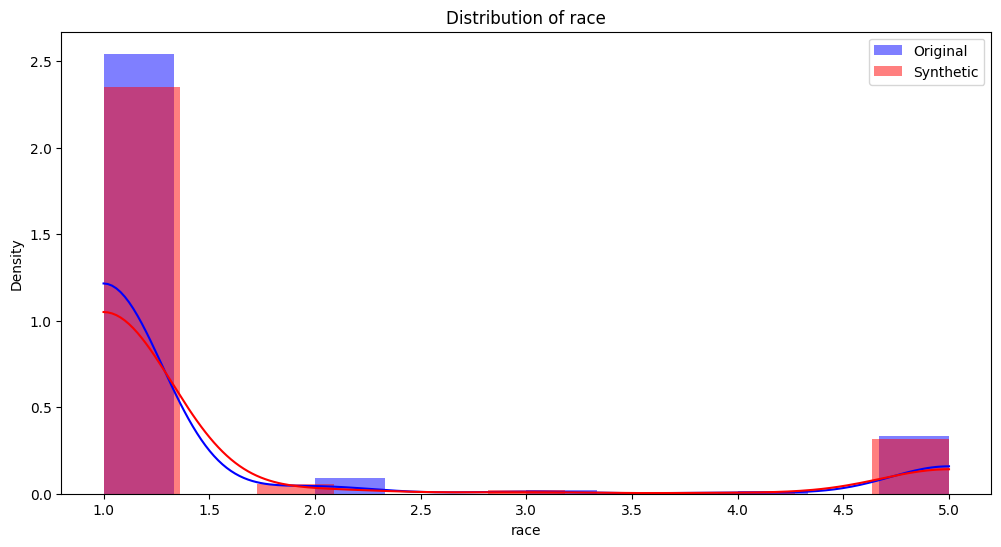

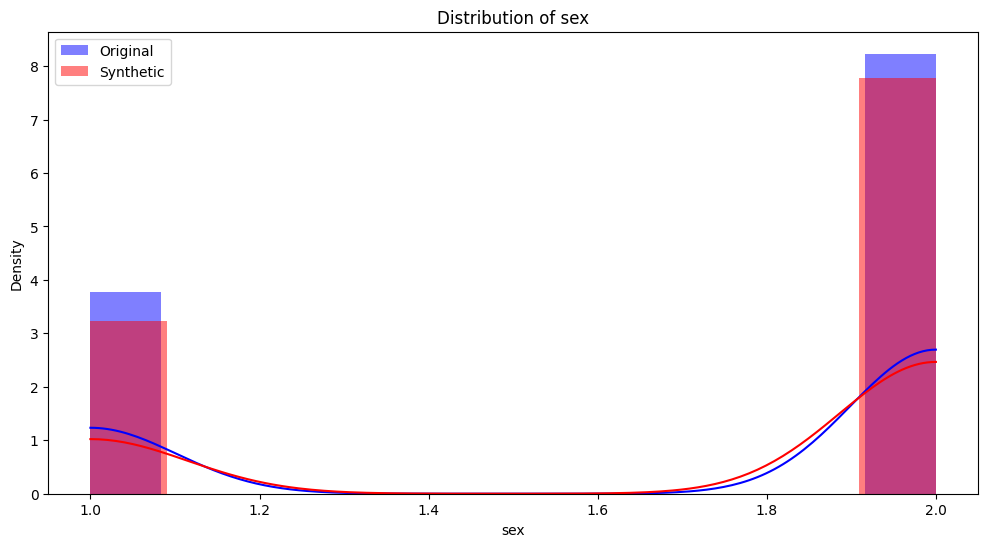

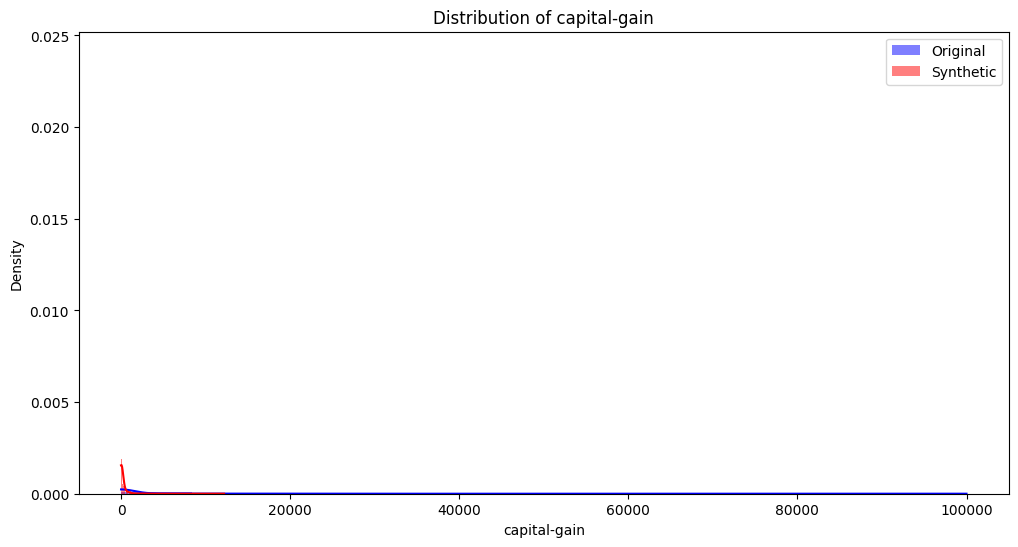

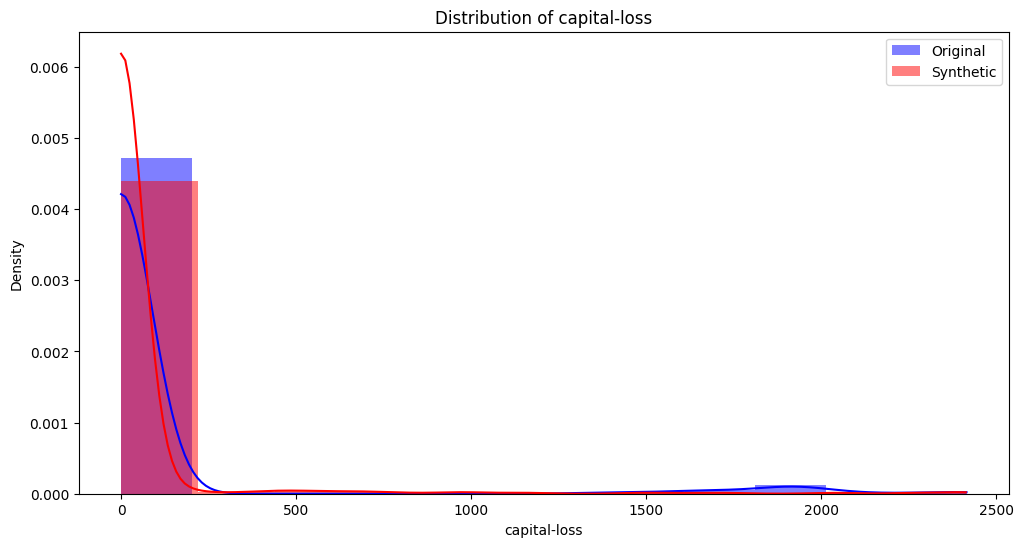

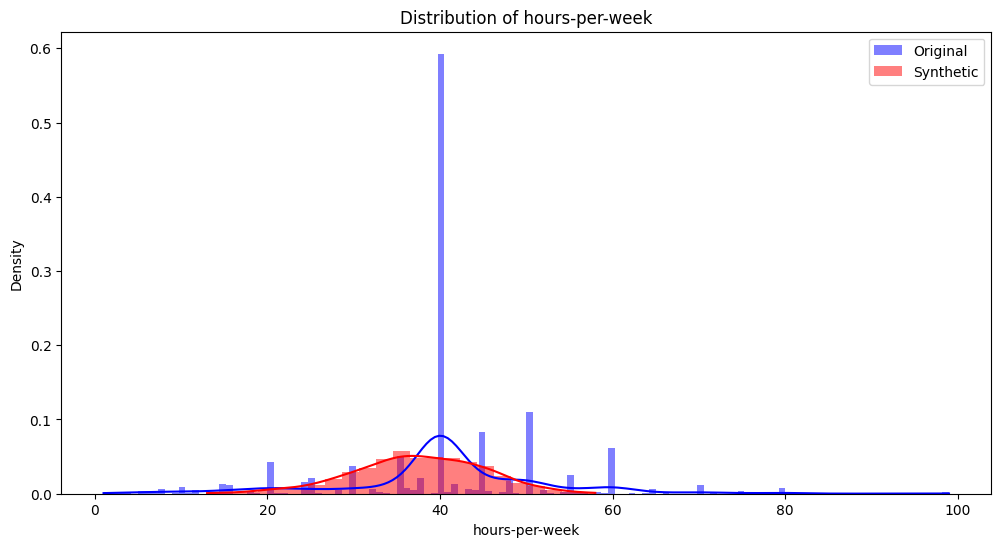

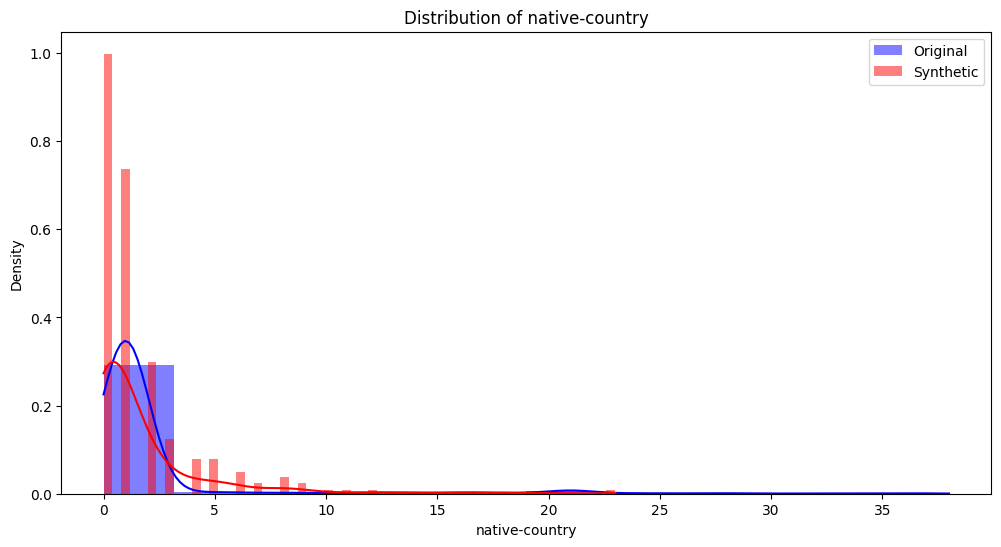

Original Data Statistics:
               age    workclass        fnlwgt    education  education-num  \
count  2000.000000  2000.000000  2.000000e+03  2000.000000    2000.000000   
mean     38.869000     1.636000  1.909227e+05     4.332500      10.111500   
std      13.391583     1.479053  1.066236e+05     3.393037       2.519572   
min      17.000000     0.000000  1.930200e+04     1.000000       1.000000   
25%      28.000000     1.000000  1.184985e+05     2.000000       9.000000   
50%      38.000000     1.000000  1.794620e+05     4.000000      10.000000   
75%      48.000000     1.000000  2.409275e+05     4.000000      13.000000   
max      90.000000     7.000000  1.033222e+06    16.000000      16.000000   

       marital-status   occupation  relationship         race          sex  \
count     2000.000000  2000.000000   2000.000000  2000.000000  2000.000000   
mean         2.032500     5.339000      3.374000     1.501000     1.686000   
std          1.122976     3.193772      1.2312

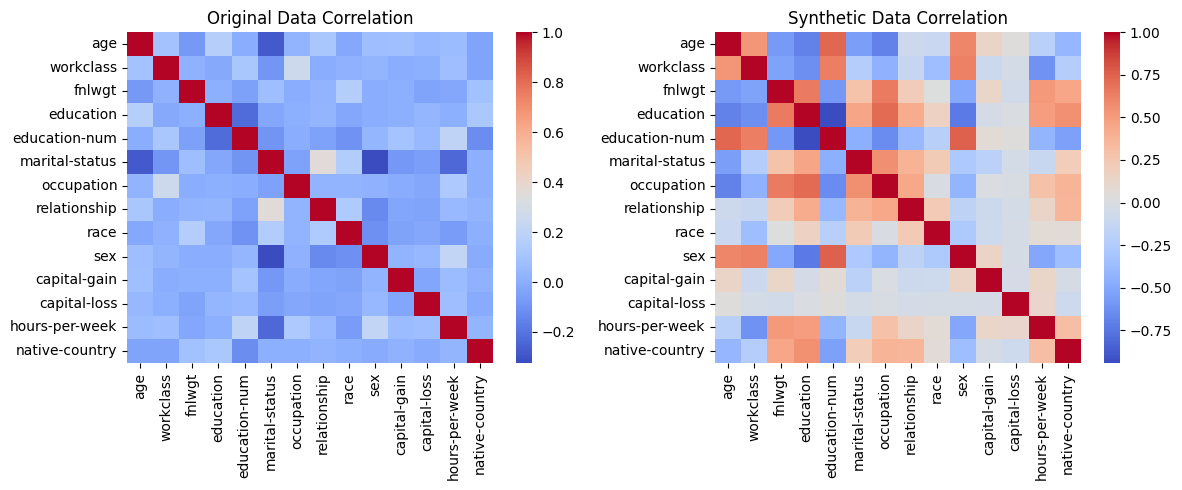

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_distributions(original, synthetic, feature_name):
    plt.figure(figsize=(12, 6))
    sns.histplot(original[feature_name], color="blue", kde=True, stat="density", linewidth=0, label="Original")
    sns.histplot(synthetic[feature_name], color="red", kde=True, stat="density", linewidth=0, label="Synthetic")
    plt.title(f'Distribution of {feature_name}')
    plt.legend()
    plt.show()

# Compare distributions for all features
for feature in X.columns:
    compare_distributions(X, processed_synthetic_data, feature)

# Calculate and print basic statistics for each feature
print("Original Data Statistics:")
print(X.describe())
print("\nSynthetic Data Statistics:")
print(processed_synthetic_data.describe())

# Calculate and print correlation matrices
print("\nOriginal Data Correlation Matrix:")
print(X.corr())
print("\nSynthetic Data Correlation Matrix:")
print(processed_synthetic_data.corr())

# Optionally, visualize correlation matrices
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title("Original Data Correlation")
plt.subplot(122)
sns.heatmap(processed_synthetic_data.corr(), annot=False, cmap='coolwarm')
plt.title("Synthetic Data Correlation")
plt.tight_layout()
plt.show()